### Run onece, to check environment

In [1]:
#!pip3 install -r requirements.txt

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
behaviors = 'MINDlarge_train/behaviors.tsv'
news = 'MINDlarge_train/news.tsv'
entityEmbedding = 'MINDlarge_train/entity_embedding.vec'

In [3]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist,cosine,cdist,squareform
import numpy.ma as ma

def clustering(X,vectorColumns,threshold,lam,withCentroid=False):
    ''' X 
            [dataframe] group of user history
        vectorColumns 
            [array like] embedding columns V1,V2....V300
        threshold
            [number] threshold for ward clustering
        lam 
            [number] paramter for importance sampling
       '''
    m,n = X.shape
    #print(X)
    if m>1:
        pairwise_distance = pdist(X[vectorColumns], metric='cosine')
        
        labels = fcluster(ward(pairwise_distance), t=threshold, criterion='distance')
        #print(labels)
        num_clusters = labels.max()
        
        scores = {}
        for i in range(num_clusters):
            c = i+1 #choose cluster
            #if we use sum, both consider number of item and time importance
            importance_score = X.loc[labels==c].importance.sum()
            scores[c] = importance_score
        
        if num_clusters>3:
            p = np.array(list(scores.values()))
            sum_score = p.sum()
            p /= sum_score
            chosed = np.random.choice(list(scores.keys()),p=p,size=3,replace=False)
        else:
            chosed = np.array(list(scores.keys()))
            
        
        medoids = []
        distance_upper_bound = []
        
        pairwise = squareform(pairwise_distance) 
        
        if withCentroid:
            centroids = []
           
            
        for c in chosed:
            idx = np.argwhere(labels==c).flatten()
            len_idx = len(idx)
        
            
            mask = np.ones(pairwise.shape,dtype=int)
            
            for j in idx:
                mask[j,idx]=0
            masked_pairwise = ma.array(pairwise, mask = mask)
            
            if withCentroid:
                mean_vector = X.loc[X.index[idx]][vectorColumns].mean().values
            
            if len_idx<3:
                distance_upper_bound.append(0.5)   
                medoids.append(X.loc[X.index[idx[0]]][vectorColumns].values)
                if withCentroid:
                    centroids.append(mean_vector) 
                continue
            min_distance_i = masked_pairwise.sum(axis=1).argmin()
            distances_i = masked_pairwise.compressed().reshape((len_idx,len_idx))[0]
            distances_i = distances_i[~(distances_i==0)]
            
            #68%-95%-99.8% for 1,2,3 std
            #!!!!!however
            #according to the result, larger cluster has lower std.
            
            distance_upper_bound.append(distances_i.mean()+2*distances_i.std())   
            medoids.append(X.loc[X.index[min_distance_i]][vectorColumns].values)
            
            if withCentroid:
                centroids.append(mean_vector)
            
        if withCentroid:
            return medoids,centroids,distance_upper_bound
        else:
            return medoids,distance_upper_bound
    else:
        if withCentroid:
            return X[vectorColumns].values,X[vectorColumns].values,0.5*np.ones(X.shape[0])
        else:
            return X[vectorColumns].values,0.5*np.ones(X.shape[0])

def randomSelection(X, vectorColumns):
    return X.sample()[vectorColumns].values, 0.5

def lastArticleSelection(X, vectorColumns):
    return [X.loc[X.index[len(X)-1]][vectorColumns].values], 0.5

def baselineTest(df_history, method="random"):
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_news_meta = pd.read_csv('generate/news_cleaned.csv')

    df_history = df_history.merge(df_news_embedding,on='NID')
    df_history = df_history.merge(df_news_meta,on='NID')

    vectorColumns = [c for c in df_history.columns if c.startswith('V')]

    records_medoid = []
    for UID,g in df_history.groupby('UID'):
        
        if method=="random":
            medoid,radius = randomSelection(g, vectorColumns)
        elif method=="last":
            medoid,radius = lastArticleSelection(g, vectorColumns)
        
        record = []
        record.append(UID)
        record+=medoid[0].tolist()
        record.append(0.5)
        records_medoid.append(record)

    df_medoid = pd.DataFrame.from_records(records_medoid,columns=['UID']+vectorColumns+['radius'])
    return df_medoid
    
def clusteringBatch(df_history,t0,threshold=0.7,lam=0.01,withCentroid=False,method="ward",constantRadius=0.0):
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_news_meta = pd.read_csv('generate/news_cleaned.csv')
    
    #df_history = df_history[df_history.UID=='U1']
 
    df_history = df_history.merge(df_news_embedding,on='NID')
    df_history = df_history.merge(df_news_meta,on='NID')


    df_history['importance'] = np.exp(-lam*(t0-df_history.publishDate)/100000)

    vectorColumns = [c for c in df_history.columns if c.startswith('V')]

    if withCentroid:
        records_medoid = []
        records_centroid = []
        
        for UID,g in df_history.groupby('UID'):
            medoid,centroid,radius = clustering(g,vectorColumns,threshold,lam,withCentroid)
        
            len_centroid = len(centroid)
        
            for c in range(len_centroid):
                record = []
                record.append(UID)
                record+=centroid[c].tolist()
                if constantRadius != 0.0:
                    record.append(constantRadius)
                else:                    
                    record.append(radius[c])
                records_centroid.append(record)

                record = []
                record.append(UID)
                record+=medoid[c].tolist()
                if constantRadius != 0.0:
                    record.append(constantRadius)
                else:                    
                    record.append(radius[c])
                records_medoid.append(record)
        
        df_centroid = pd.DataFrame.from_records(records_centroid,columns=['UID']+vectorColumns+['radius'])
        df_medoid = pd.DataFrame.from_records(records_medoid,columns=['UID']+vectorColumns+['radius'])
        return df_medoid,df_centroid
    else:
        medoid,radius = clustering(g,vectorColumns,threshold,lam,withCentroid)
        
        len_medoid = len(medoid)
        
        for c in range(len_centroid):
            record = []
            record.append(UID)
            record+=centroid[c].tolist()
            record.append(radius[c])
            records_medoid.append(record)
                
        
        df_medoid = pd.DataFrame.from_records(records_medoid,columns=['UID']+vectorColumns+['radius'])
        return df_medoid

### what if use centroid of clustering as user representation

In [4]:
def measurement(df_impression,df_user_representation):
    df_impression = df_impression[df_impression.attitude==1]
    
    #df_impression = df_impression[df_impression.UID=='U1']
    
    df_news_embedding = pd.read_csv('generate/news_embedding.csv')
    df_impression = df_impression.merge(df_news_embedding,on='NID')
    
    vectorColumns = [c for c in df_impression.columns if c.startswith('V')]
        
    measure = []
    for UID,g in df_impression.groupby('UID'):
        
        user = df_user_representation[df_user_representation.UID==UID]
        
        if len(user)==0:
            continue
        
        user_radius = user.radius.values
        user = user[vectorColumns].values
        
        positive = g[vectorColumns]
        
        d = cdist(positive,user, metric='cosine')
       
        #at least one distance in radius
        hits = (d<user_radius).sum(axis=1)>0
        recall = hits.mean()
        
        hits_d = d[hits]
        where_clusters = hits_d.argmin(axis=1)
        
        hit = 1 - len(np.unique(where_clusters))/len(user)
       
        measure.append((UID,recall,hit))
        
    return pd.DataFrame.from_records(measure,columns=['UID','recall','percent_empty'])

In [5]:
def getResults(history,impression,t0,threshold,lam):
    res = []
    print("Clustering...")
    medoids,centroids = clusteringBatch(history,t0,threshold=threshold,lam=lam,withCentroid=True,constantRadius=0.5)
    print("Evaluating...")
    m_c = measurement(impression,centroids)
    m_m = measurement(impression,medoids)
    print(m_m)
    res.append(threshold)
    res.append(lam)
    res.append(m_m.recall.mean()) 
    res.append(m_m.percent_empty.mean())
    res.append(medoids.radius.mean())
    res.append(medoids.groupby("UID").size().mean())
    res.append(m_c.recall.mean()) 
    res.append(m_c.percent_empty.mean())
    res.append(centroids.radius.mean())
    res.append(centroids.groupby("UID").size().mean())
    return res

def evaluate(subsetNr, size=-1):
    history = 'generate/user_history_'+subsetNr+'.csv'
    impression = 'generate/user_impressions_'+subsetNr+'.csv'
    df_impression = pd.read_csv(impression)
    df_history = pd.read_csv(history)
    if size != -1:
        df_impression = df_impression[0:size]
    t0 = 1575586800+1000
    result = []
    lam = [0.01]
    threshold = [0.5, 0.75, 1.0, 1.25, 1.50, 2.0, 3.0, 4.0, 5.0]
    for t in threshold:
        for l in lam:
            print("Running with threshold", t, "and lambda", l)
            r = getResults(df_history, df_impression, t0, t, l)
            print(r)
            result.append(r)
    return pd.DataFrame(result, columns=['Threshold','Lambda','Medoid Recall','Empty medoids','Medoid radius','Medoids per user','Centroid Recall','Empty centroids','Centroid radius','Centroids per user'])


In [ ]:
df = evaluate("12",-1)

In [205]:
#df.to_csv("threshold_tuning.csv")

In [204]:
df

,Threshold,Lambda,Medoid Recall,Empty medoids,Medoid radius,Medoids per user,Centroid Recall,Empty centroids,Centroid radius,Centroids per user
0,0.50,0.01,0.425352,0.674440,0.5,2.825333,0.443205,0.663246,0.5,2.825333
1,0.75,0.01,0.436129,0.666356,0.5,2.708751,0.463239,0.651430,0.5,2.708751
2,1.00,0.01,0.425496,0.647388,0.5,2.497350,0.480403,0.605721,0.5,2.497350
3,1.25,0.01,0.417024,0.621580,0.5,2.263415,0.486767,0.558769,0.5,2.263415
4,1.50,0.01,0.422485,0.586443,0.5,2.061326,0.505200,0.509950,0.5,2.061326
5,2.00,0.01,0.397349,0.542910,0.5,1.765653,0.502706,0.443719,0.5,1.765653
6,3.00,0.01,0.369840,0.492226,0.5,1.435098,0.480855,0.376866,0.5,1.435098
7,4.00,0.01,0.356772,0.453980,0.5,1.266656,0.472508,0.328980,0.5,1.266656
8,5.00,0.01,0.350630,0.433458,0.5,1.175233,0.469527,0.311878,0.5,1.175233


### Medoid vs. Centroid

In [ ]:
t0 = 1575586800+1000
lam = 10.0
threshold = 2.0

df_history = pd.read_csv('generate/user_history_15.csv')
df_impression = pd.read_csv('generate/user_impressions_15.csv')

df_user_representation_medoid,df_user_representation_centroid = clusteringBatch(df_history,t0,threshold=threshold,lam=lam,withCentroid=True,constantRadius=0.5)

In [144]:
df_measure_centroid = measurement(df_impression,df_user_representation_centroid)

In [145]:
print(df_measure_centroid.recall.mean())
print(df_measure_centroid.percent_empty.mean())

0.5500713974872775
0.4142661179698219


In [118]:
df_measure_medoid = measurement(df_impression,df_user_representation_medoid)

In [119]:
print(df_measure_medoid.recall.mean())
print(df_measure_medoid.percent_empty.mean())

0.39647701646198247
0.4348422496570646


In [142]:
df_user_representation_medoid.groupby("UID").size().mean()

1.783522057693293

### Random medoid test

In [6]:
df_history = pd.read_csv('generate/user_history_15.csv')
df_impression = pd.read_csv('generate/user_impressions_15.csv')

df_user_representation_random = baselineTest(df_history,method="random")

In [7]:
df_measure_random = measurement(df_impression,df_user_representation_random)
df_measure_random.recall.mean()

0.25026765207411555

In [8]:
df_measure_random.percent_empty.mean()

0.5370370370370371

### Last article medoid test

In [10]:
df_history = pd.read_csv('generate/user_history_0.csv')
df_impression = pd.read_csv('generate/user_impressions_0.csv')

df_user_representation_lastarticle = baselineTest(df_history,method="last")

In [11]:
df_measure_lastarticle = measurement(df_impression,df_user_representation_lastarticle)
df_measure_lastarticle.recall.mean()

0.23833824299169687

In [12]:
df_measure_lastarticle.percent_empty.mean()

0.5779467680608364

<AxesSubplot:>

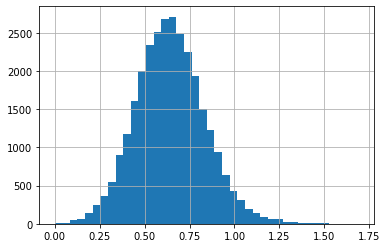

In [371]:
df_user_representation[~(df_user_representation.radius==0.5)].radius.hist(bins=40)